# Exercise 1

## a)

First of all, we import some usefull libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

From probabilistics we now that:

\begin{equation} P(A|B) = \frac{P(A,B)}{P(B)} \end{equation}

So, we're using Bayer classifier in orther to calculate probability of survival taking into account two variables:

\begin{equation} P(survive|sex,class) = \frac{P(survive,sex,class)}{P(sex,class)} \end{equation}

We're calculating it for each case.

In [2]:
data = pd.read_csv("titanic3.csv") # We load the data

data_pclass_sex = data[['pclass', 'sex', 'survived']] # We take only the columns we need

grouped = data_pclass_sex.groupby(['survived','sex', 'pclass']) # We make a group with this data
grouped_2 = data_pclass_sex.groupby(['survived', 'pclass', 'sex']) # We make a group with this data

counts = grouped.size()
counts_2 = grouped_2.size()

We implement previous probability equation for each case by using 'counts' function for our group.

In [3]:
P_sex_class = np.zeros(6)

pos = 0
for sex in ['male','female']:
    for i in np.arange(1,4):
        P_sex_class[pos] = np.float(counts[(1, sex, i)]) / (counts[(1, sex, i)] + counts[(0, sex, i)])
        pos += 1

So we have next results of probability of survival, where it starts on male sex, and class grows from first to third.

In [4]:
print('Class: 1, 2, 3')
print('Male:', np.round(P_sex_class[0:3], 3))
print('Female:', np.round(P_sex_class[3:], 3))

Class: 1, 2, 3
Male: [0.341 0.146 0.152]
Female: [0.965 0.887 0.491]


## b)

We calculate the total number of predicted survivors, and the truly one (labels). We should use classes, but this way is simplier when we have not a lot of cases.

In [5]:
n = len(data_pclass_sex)

labels = data_pclass_sex['survived'] # True values of survived people

predicted = np.zeros(n)

for i in range(n):
    if data_pclass_sex['sex'][i] == 'male':
        if data_pclass_sex['pclass'][i] == 1:
            predicted[i] = P_sex_class[0]
        elif data_pclass_sex['pclass'][i] == 2:
            predicted[i] = P_sex_class[1]
        else:
            predicted[i] = P_sex_class[2]
    else:
        if data_pclass_sex['pclass'][i] == 1:
            predicted[i] = P_sex_class[3]
        elif data_pclass_sex['pclass'][i] == 2:
            predicted[i] = P_sex_class[4]
        else:
            predicted[i] = P_sex_class[5]

Now, we calculate TPR and FPR using sklearn.metrics, with roc_curve (a built in function).

In [6]:
fpr, tpr, ths = roc_curve(labels, predicted)

print('TPR =', np.round(tpr, 3))
print('FPR =', np.round(fpr, 3))

TPR = [0.    0.278 0.466 0.678 0.8   0.95  1.   ]
FPR = [0.    0.006 0.021 0.157 0.303 0.82  1.   ]


After that, we can plot it, so we see that it has a good behaviour: its higher than a stright line from [0,0] to [1,1], which is randomly classified. This would be the standart classifier with TPR, FPR = [0, 1], which we're ploting with a red line.

We can study it numerically by using AUC score, calculated with a built-in function.

AUC score: 0.8200012360939432


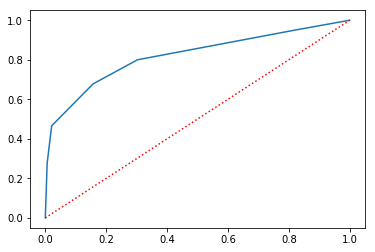

In [7]:
print('AUC score:', roc_auc_score(labels, predicted))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ':r')

## c)

We want to verify if class and sex features are or not independent.

In order to do that, we firstly calculate propability $P(sex, class|survive)$, so we apply next equation:

\begin{equation} P(sex, class|survive) = \frac{P(sex, class, survive)}{P(survive)} \end{equation}

If they are conditional independent, this probability should be equal to the product P(sex|survive)P(class|survive):

\begin{equation} P(sex|survive)P(class|survive) = \frac{P(sex, survive)P(class, survive)}{P(survive)^2} \end{equation}

We're doing that for survivors or not.

In [8]:
N_passengers = len(data_pclass_sex['survived'])
P_survival = np.count_nonzero(labels == 1) / N_passengers
P_non_survival = np.count_nonzero(labels == 0) / N_passengers

def P_survival_sex_class(sex, pclass, i):
    return counts[i][sex][pclass] / N_passengers

def P_survival_sex(sex, i):
    return sum(counts[i][sex]) / N_passengers

def P_survival_class(pclass, i):
    return sum(counts_2[i][pclass]) / N_passengers

So, we can proceed to calculate expected values for our passengers, and we'll see if they are or not independent.

In [9]:
predicted_1_s, predicted_2_s = 0, 0 # Survivals
predicted_1_ns, predicted_2_ns = 0, 0 # Not survivals
cases = 0

for sex in ['male', 'female']:
    for pclass in np.arange(1, 4):
        predicted_1_s = np.append(predicted_1_s, P_survival_sex_class(sex, pclass, 1) / P_survival)
        predicted_1_ns = np.append(predicted_1_ns, P_survival_sex_class(sex, pclass, 0) / P_non_survival)
        
        predicted_2_s = np.append(predicted_2_s, P_survival_sex(sex, 1) * P_survival_class(pclass, 1) / P_survival**2)
        predicted_2_ns = np.append(predicted_2_ns, P_survival_sex(sex, 0) * P_survival_class(pclass, 0) / P_non_survival**2)
        cases += 1

predicted_1_s, predicted_2_s = np.delete(predicted_1_s, 0), np.delete(predicted_2_s, 0)
predicted_1_ns, predicted_2_ns = np.delete(predicted_1_ns, 0), np.delete(predicted_2_ns, 0)

We can plot our results, so we can see they're not really different. In fact, both curves move the same way, so we can assume that they are pretty independent.

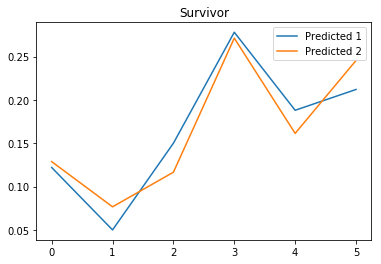

In [10]:
plt.plot(range(cases), predicted_1_s, label = u'Predicted 1')
plt.plot(range(cases), predicted_2_s, label = u'Predicted 2')
plt.legend(loc = 'best')
plt.title(u'Survivor')
plt.show()

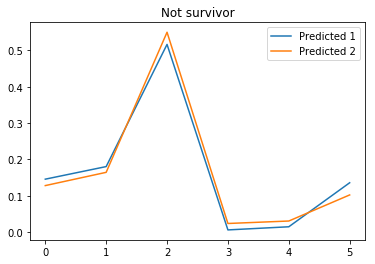

In [11]:
plt.plot(range(cases), predicted_1_ns, label = u'Predicted 1')
plt.plot(range(cases), predicted_2_ns, label = u'Predicted 2')
plt.legend(loc = 'best')
plt.title(u'Not survivor')
plt.show()

Now, we can study it numerically, so we're using Pearson correlation coefficient, which is the covariance of the two variables divided by the product of their standard deviations. Since this coefficients are very hight, we can conclude that they are highly independent.

In [12]:
print('Pearson correlation coefficient (survival) =', np.corrcoef(predicted_1_s, predicted_2_s)[1, 0])
print('Pearson correlation coefficient (non survival) =', np.corrcoef(predicted_1_ns, predicted_2_ns)[1, 0])

Pearson correlation coefficient (survival) = 0.9378679574725755
Pearson correlation coefficient (non survival) = 0.992053580317471


## d)

Once we saw those features were highly independent, we're applying next relation, directly from Naive Bayes definition:

\begin{equation} P_{NB}(survive|sex, class) = \frac{P(sex, survive)P(class, survive)}{P(survive)P_{NB}(sex, class)} \end{equation}

Where:

\begin{equation} P_{NB}(sex, class) = P_{NB}(sex, class|surv = 0)P(surv = 0) + P_{NB}(sex, class|surv = 1)P(surv = 1) \end{equation}

We first calculate probability of survive or not.

In [13]:
N_passengers = len(data_pclass_sex['survived'])
P_survival = np.count_nonzero(labels == 1) / N_passengers
P_non_survival = np.count_nonzero(labels == 0) / N_passengers

Now, we calculate probability of each class and sex conditionated to survive or not, as well as probability of sex and class.

At the beginning of the code we defined counts_2, which has same data of counts, but differently organized (we'll be able to count all passengers of a class, independently of their sex).

In [14]:
def P_NB_sex_class(sex, pclass):
    return P_non_survival * counts[0][sex][pclass] / N_passengers + P_survival * counts[1][sex][pclass] / N_passengers

def P_survival_sex(sex, i):
    return sum(counts[i][sex]) / N_passengers

def P_survival_class(pclass, i):
    return sum(counts_2[i][pclass]) / N_passengers

After that, we can calculate probability of surviving for each class and sex using Naives Bayes method.

In [15]:
def Naive_Bayes(sex, pclass):
    predicted_survive = P_survival_sex(sex, 1) * P_survival_class(pclass, 1) / P_survival / P_NB_sex_class(sex, pclass)
    predicted_non_survive = P_survival_sex(sex, 0) * P_survival_class(pclass, 0) / P_non_survival / P_NB_sex_class(sex, pclass)
    
    aux = 'survive'
    if predicted_survive < predicted_non_survive:
        aux = 'non survive'
    
    return predicted_survive, predicted_non_survive, aux

for sex in ['male', 'female']:
    print('A', sex, ': \n')
    for pclass in np.arange(1, 4):
        predicted_survive_aux, predicted_non_survive_aux, result = Naive_Bayes(sex, pclass)
        print('In class', pclass, 'will', result)
    print('\n')

A male : 

In class 1 will non survive
In class 2 will non survive
In class 3 will non survive


A female : 

In class 1 will survive
In class 2 will survive
In class 3 will survive




In order to validate the method we calculate all predicted cases. Since we're also calculating accuracy, it can take a bit more time to develop the loop.

In [16]:
predicted_2 = np.zeros(N_passengers)
binary_predicted = np.zeros(N_passengers)

for i in range(N_passengers):
    predicted_2[i] = Naive_Bayes(data['sex'][i], data['pclass'][i])[0]
    binary_predicted_aux = Naive_Bayes(data['sex'][i], data['pclass'][i])[2]
    if binary_predicted_aux == 'survive':
        binary_predicted[i] = 1

print('The classiffier has an accuracy of:', np.count_nonzero(binary_predicted == labels) / N_passengers)

The classiffier has an accuracy of: 0.7799847211611918


Then, we calculate TPR and FPR using sklearn.metrics, with roc_curve (a built-in function).

In [17]:
fpr, tpr, ths = roc_curve(labels, predicted_2)

print('TPR =', np.round(tpr, 3))
print('FPR =', np.round(fpr, 3))

TPR = [0.    0.278 0.466 0.678 0.8   0.85  1.   ]
FPR = [0.    0.006 0.021 0.157 0.303 0.483 1.   ]


Now, we can plot it, so we see that it has a good behaviour: its higher than a stright line from [0,0] to [1,1], which is randomly classified. We can study it numerically by using AUC score, calculated with another built in-function.

Nevertheless, we can see that AUC score is smaller that for Bayer classifier. It could be due to that those features were not independet at all.

AUC score: 0.8187651421508035


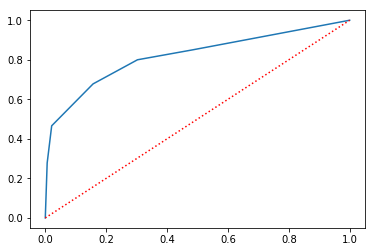

In [18]:
print('AUC score:', roc_auc_score(labels, predicted_2))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], ':r')

# Exercise 2

Now, we're adding age feature, so we're extending previous classifier.

\begin{equation} P_{NB}(survive|sex, class, age) = \frac{P(sex, survive)P(class, survive)P(age, survive)}{P(survive)P_{NB}(sex, class, age)} \end{equation}

Where:

\begin{equation} P_{NB}(sex, class, age) = P_{NB}(sex, class, age|surv = 0)P(surv = 0) + P_{NB}(sex, class, age|surv = 1)P(surv = 1) \end{equation}

We're using all probabilities calculated in previous section, but we're now calculating probabilities of each age conditionated to survive or not. First of all, we're diving people from ages into: child, adult and senior.

In [19]:
data_with_age = data_pclass_sex.copy()
data_with_age['age'] = data['age']
N_ages = np.count_nonzero(data['age'].fillna(0))

limits, lbls = [18,65], ['child','adult','senior']

def categorizer(age):
        for i, l in enumerate(limits):
            if age <= l:
                return lbls[i]
        return lbls[-1]   

def make_age_categorizer(limits, lbls):  
    return categorizer

ctg = make_age_categorizer(limits, lbls)
data_with_age['age_category'] = data_with_age.age.apply(ctg)
counts_with_age = data_with_age.groupby(['survived', 'age_category', 'sex', 'pclass']).size()

Now, as we did in previous exercise, we define usefull functions. We use N_ages because not all passengers has that information.

In [20]:
def P_NB_sex_class_age(sex, pclass, age_group):
    return P_non_survival * counts_with_age[0][age_group][sex][pclass] / N_ages + P_survival * counts_with_age[1][age_group][sex][pclass] / N_ages

def P_survival_age(age_group, i):
    return sum(counts_with_age[i][age_group]) / N_ages

Now, we define a function to calculate probability in each case, and another one to calculate Naive Bayes probability, because we have too many cases to represent all of them.

We have some gaps in age data, so we're using previous Naive Bayes classifier when needed.

In [21]:
def Naive_Bayes_2(sex, pclass, age):
    try:
        age_group = categorizer(age)
        predicted_survive = P_survival_sex(sex, 1) * P_survival_class(pclass, 1) * P_survival_age(age_group, 1) / P_survival / P_NB_sex_class_age(sex, pclass, age_group)
        predicted_non_survive = P_survival_sex(sex, 0) * P_survival_class(pclass, 0) * P_survival_age(age_group, 0) / P_non_survival / P_NB_sex_class_age(sex, pclass, age_group)

        aux = 'survive'
        if predicted_survive < predicted_non_survive:
            aux = 'non survive'
        return predicted_survive, predicted_non_survive, aux
    except:
        return Naive_Bayes(sex, pclass) # When we don't have information about ages

for sex in ['male','female']:
    print('A', sex, ': \n')
    for i in np.arange(1,4):
        print('In class', i, ': \n')
        for j in range(3):
            possible_ages = [5, 40, 70]
            print(categorizer(possible_ages[j]), 'will', Naive_Bayes_2(sex, i, possible_ages[j])[2])
        print('\n')

A male : 

In class 1 : 

child will non survive
adult will non survive
senior will non survive


In class 2 : 

child will non survive
adult will non survive
senior will non survive


In class 3 : 

child will non survive
adult will non survive
senior will non survive


A female : 

In class 1 : 

child will survive
adult will survive
senior will survive


In class 2 : 

child will survive
adult will survive
senior will survive


In class 3 : 

child will survive
adult will non survive
senior will non survive




In [22]:
predicted = np.zeros(N_passengers)
binary_predicted = np.zeros(N_passengers)

for i in range(N_passengers):
    predicted[i] = Naive_Bayes_2(data['sex'][i], data['pclass'][i], data['age'][i])[0]
    binary_predicted_aux = Naive_Bayes_2(data['sex'][i], data['pclass'][i], data['age'][i])[2]
    if binary_predicted_aux == 'survive':
        binary_predicted[i] = 1

print('The classiffier has an accuracy of:', np.count_nonzero(binary_predicted == labels) / N_passengers)

The classiffier has an accuracy of: 0.786096256684492


Now we calculate TPR and FPR using sklearn.metrics, with roc_curve (a built in function).

In [23]:
fpr, tpr, ths = roc_curve(labels, predicted)

print('TPR =', np.round(tpr, 3))
print('FPR =', np.round(fpr, 3))

TPR = [0.    0.004 0.028 0.052 0.064 0.294 0.334 0.416 0.56  0.622 0.644 0.648
 0.716 0.808 0.826 0.85  0.88  0.968 1.   ]
FPR = [0.    0.001 0.001 0.002 0.005 0.01  0.011 0.077 0.089 0.122 0.135 0.151
 0.188 0.302 0.331 0.483 0.554 0.839 1.   ]


Finally, we can plot it, so we see that it has a good behaviour: its higher than a stright line from [0,0] to [1,1], which is randomly classified. We can study it numerically by using AUC score, calculated with a built in function.

We get very similar values to the previous classiffier, which didn't take age group into account. What's more, now, AUC score is a bit smaller, instead accuracy is bigger.

AUC score: 0.8164932014833127


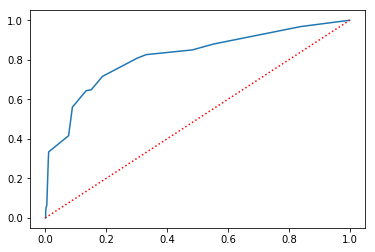

In [24]:
print('AUC score:', roc_auc_score(labels, predicted))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ':r')